In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm

import random
import os, errno
import sys
from tqdm import trange

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

import matplotlib.pyplot as plt


from lstm_encoder_decoder import *

C:\Users\Febrin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Data

Each trajectory is represented by a N x M matrix,

where N is the number of stay points, and M i number of all POIs


In [2]:
M = 100

x = np.array(
    [
        [np.random.randint(0, 10) for _ in range(3)]
        for __ in range(10)
    ]
)
x

array([[0, 6, 0],
       [0, 0, 5],
       [0, 3, 3],
       [2, 6, 1],
       [1, 7, 2],
       [9, 3, 9],
       [5, 4, 6],
       [6, 3, 4],
       [3, 5, 7],
       [6, 6, 2]])

In [3]:
%%time
def normalize(x):
    x = np.array(x)
    return x / (x.sum() + 1e-18)

dataset = [
    np.array(
        [
            normalize([np.random.randint(0, 10) for _ in range(M)])
            for __ in range(np.random.randint(10, 50))
        ]
    )
    for ___ in range(1000)
]


CPU times: total: 6.84 s
Wall time: 7.02 s


## Training

In [5]:
n_epochs = 2
batch_size = 1
learning_rate = 0.01

model = EncoderDecoder(input_size=M, hidden_size=2)

optimizer = optim.Adam(model.parameters(), lr = learning_rate)
criterion = nn.MSELoss()

losses = []
for epoch in tqdm(range(n_epochs)):
    
    for i, x in enumerate(dataset):
        input_batch = torch.from_numpy(x).type(torch.Tensor).view(1, *x.shape)
#         print(input_batch.shape)
        
        # initialize hidden state
        encoder_hidden = model.encoder.init_hidden(batch_size)

        # zero the gradient
        optimizer.zero_grad()
        
         # encoder outputs
        encoder_output, encoder_hidden = model.encoder(input_batch)
        
#          # outputs tensor
#         target_len = len(input_batch)
#         outputs = torch.zeros(target_len, batch_size, input_batch.shape[2])
                
#         # decoder with teacher forcing
#         decoder_input = input_batch[-1, :, :]   # shape: (batch_size, input_size)
#         decoder_hidden = encoder_hidden

#         for t in range(target_len): 
#             decoder_output, decoder_hidden = model.decoder(decoder_input, decoder_hidden)
#             decoder_input = decoder_output
            
#             print(decoder_output.shape)
#             print(outputs.shape)
#             outputs[t] = decoder_output

        decoder_output, decoder_hidden = model.decoder(input_batch[-1, :, :], encoder_hidden)
        
        loss = criterion(input_batch[0], decoder_output)
        # backpropagation
        loss.backward()
        optimizer.step()
        
        losses.append(loss)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.67s/it]


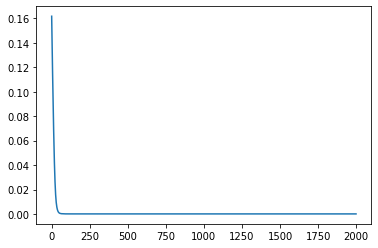

In [6]:
plt.plot([x.detach().numpy() for x in losses])

In [7]:
encoder_output, encoder_hidden = model.encoder(input_batch)

decoder_output, decoder_hidden = model.decoder(input_batch[-1, :, :], encoder_hidden)

In [8]:
criterion(decoder_output, input_batch[0])

tensor(4.2670e-05, grad_fn=<MseLossBackward>)

In [9]:
encoder_output.shape

torch.Size([1, 39, 2])

In [10]:
input_batch.shape

torch.Size([1, 39, 100])

In [11]:
decoder_output.shape

torch.Size([39, 100])

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 479.34it/s]


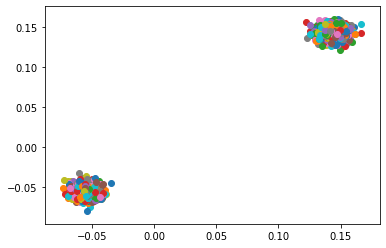

In [22]:
from matplotlib.pyplot import cm

color = cm.rainbow(np.linspace(0, 1, len(dataset)))
model = EncoderDecoder(input_size=M, hidden_size=2)

for i, x in enumerate(tqdm(dataset)):
    input_batch = torch.from_numpy(x).type(torch.Tensor).view(1, *x.shape)
    encoder_output, encoder_hidden = model.encoder(input_batch)
    
    for p in encoder_output.detach().numpy():
        plt.scatter(p[0], p[1])
        
plt.show()